# 가우시안 프로세스 (Gaussian Process)
본 코드의 목적은 가우시안 프로세스 리그레션(Gaussian Process Regression)을 통해 샘플링한 데이터를 바탕으로 실제함수를 추정하는 것입니다. 이는 관찰된 포인트 집합을 다변수 정규분포를 따르는 $T_N = [t_1, t_2, ..., t_N]^T$라고 가정하여, $T_N$을 바탕으로 $t_{N+1}$의 확률분포인 $P(t_{N+1}|T_N)$을 찾음으로써 달성할 수 있습니다.

### $P(T)$의 확률분포
먼저 연속 도메인 위 $N$개의 포인트 집합 $X_n=[x_1, x_2, ..., x_n]^T$이 $M$차원으로 매핑될 때, $M$차원의 웨이트 벡터를 $W$, 매핑된 잠재함수의 값을 $Y_n=[y_1, y_2, ..., y_n]^T$이라 할 때, 추정하는 잠재함수 $Y$의 확률분포를 구하면 다음과 같습니다.

$$P(Y) = N(W|\space0, K)$$

이때, $W=[w_1, w_2, ..., w_M]^T$, $K_{nm} = K(x_n, x_m) = \frac{1}{\alpha}\phi(x_n)\phi(x_m)$


여기서 하나의 포인트 $x_n$에 대해 실제 관측된 값을 $t_n$, 가우시안 에러를 $e_n$이라고 하면, $t_n=y_n+e_n$이 성립합니다. 이에 따라 $P(T|\space Y)$를 구하면 다음과 같습니다.

$$P(T|\space Y)=N(T|\space Y, \beta^{-1}I_N)$$

여기서 다변수 정규분포의 성질을 이용하여 단일분포 $P(T)$를 구하면 다음과 같은 식으로 나타납니다.

$$P(T)=N(T|\space 0, (\beta I_N)^{-1}+K)$$

### $P(t_{N+1})$의 확률분포
$T_N$에 $t_{N+1}$을 추가한 $T_{N+1}$의 확률분포는 다음과 같습니다.

$$P(T_{N+1})=P(T_N,\space t_{N+1})=N\left(T|\space0,\begin{pmatrix}
(\beta I_N)^{-1}+K & k_{1(N+1)} \\
k_{(N+1)1} &  k_{(N+1)(N+1)}+\beta
\end{pmatrix}\right)$$

$$cov_{N+1}=\begin{bmatrix}
cov_N & k \\
k^T &  c
\end{bmatrix}$$


다변수 정규분포의 특징을 이용하면, 위의 분포를 통해 아래의 조건분포를 구할 수 있습니다.

$$P(t_{N+1}|T_N)=N(t_{N+1}|\space 0+k^{T}cov_N^{-1}(T_N-0),\space c-k^Tcov_N^{-1}k)$$

따라서 $\mu_{t_{N+1}}|\space T_N = k^{T}cov_N^{-1}T_N,\space \sigma_{t_{N+1}}|\space T_N = c-k^Tcov_N^{-1}k$입니다.

### 커널함수
본 코드는 아래와 같은 커널함수를 이용하여 공분산행렬을 구성하고 데이터 값을 예측합니다.
$$K_{nm} = k(x_n, x_m) = \theta_0 exp(-\frac{\theta_1}{2}||x_n-x_m||^2)+\theta_2+\theta_3 x_n^T x_m$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
# 커널함수 정의
def KernelFunction(theta, X1, X2):
    ret = theta[0] * np.exp(-theta[1]/2 * np.dot((X1 - X2), (X1 - X2))) + theta[2] + theta[3]*np.dot(np.transpose(X1), X2)
    return ret

In [6]:
snr = 0.2 # signal to noise ratio
numMaxPoints = 50 # 샘플링 최대 횟수

X = np.arange(0, 2*np.pi, 0.1) # 샘플 X를 [0, 2*pi] 범위에서 0.1씩 증가시키며 생성
numTruePoints = X.shape[0] # 생성된 샘플 X의 갯수
trueY = np.sin(X) # 실제함수

theta = np.array([1, 1, 1, 1]) ##### 질문!
beta = 200

showVisualization = [1, 5, 10, 20, 30, 49] # 가시화할 샘플링 횟수

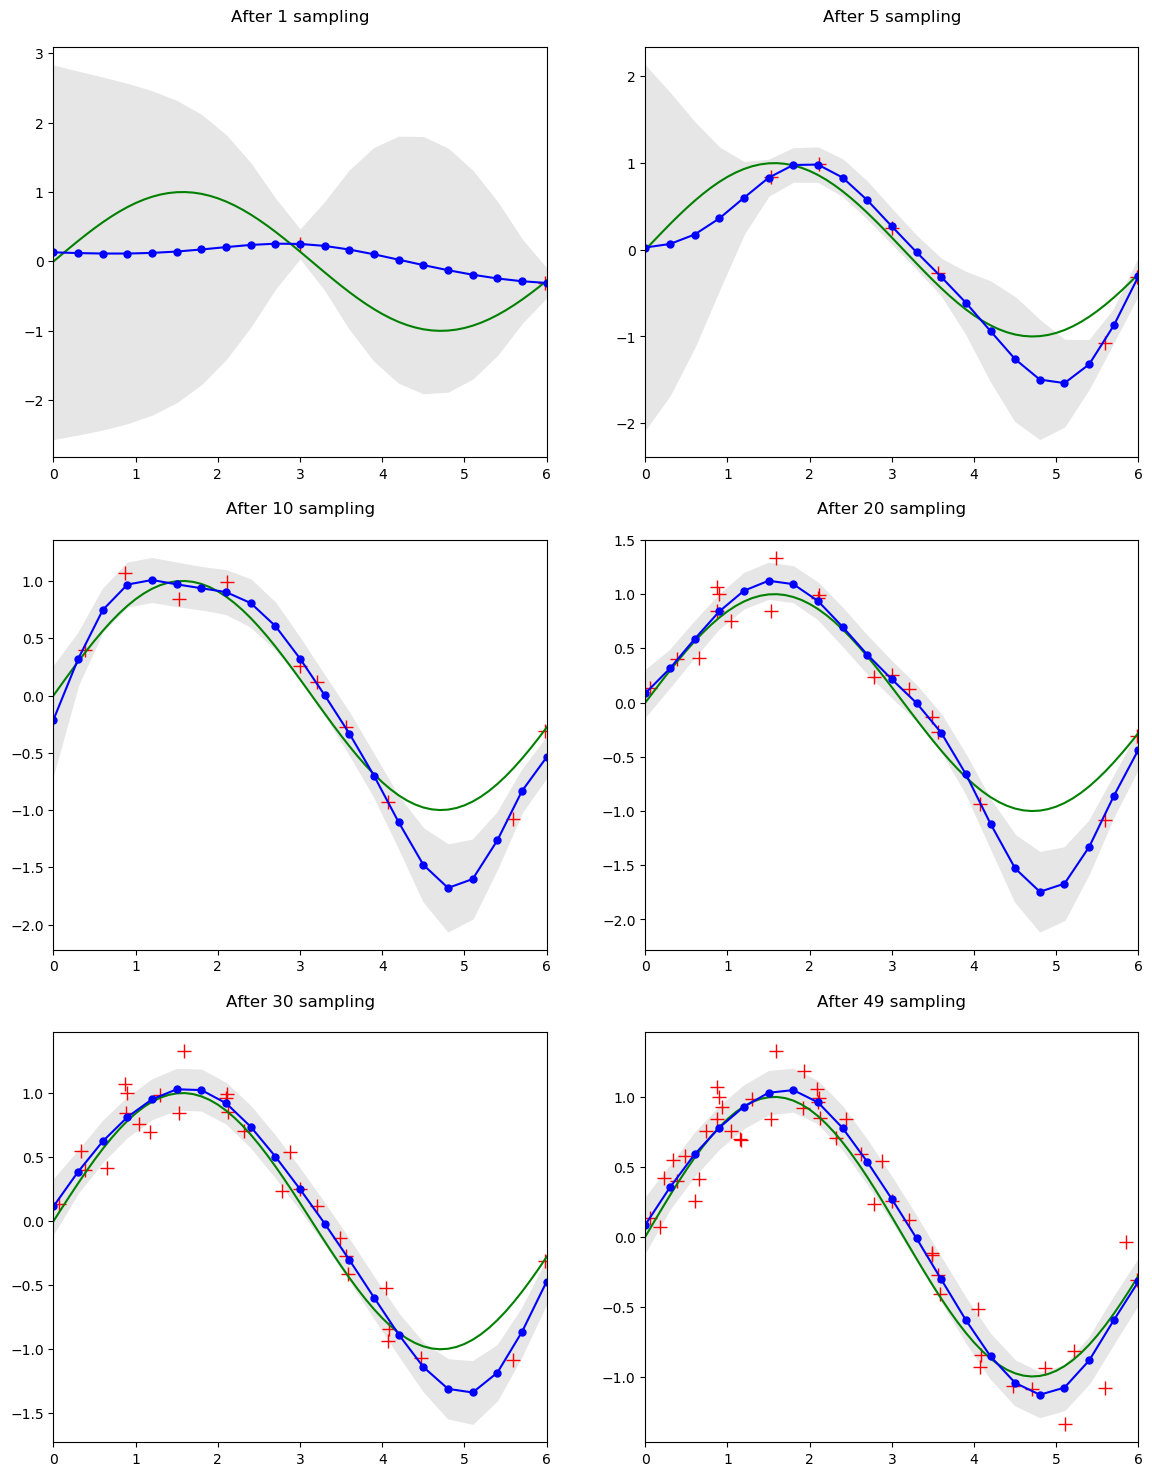

In [7]:
sampleX = []
sampleY = []

plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1

for itr2 in range(numMaxPoints):
    
    sampleX.append(2*np.pi*np.random.random())
    sampleY.append(np.sin(sampleX[-1]) + snr * np.random.randn()) 
    # sampleY는 실제함수에 노이즈(snr * np.random.randn())가 더해진 값으로 우리가 실제로 얻게 되는 데이터 값을 의미함
    numPoints = len(sampleX) # 사용하는 데이터 셋의 크기
    
    inputs = np.arange(0, 2*np.pi, 0.3) # inputs은 0에서 2pi까지 0.3 간격
    
    mu_next = []
    sigma2_next = []

    for itr1 in range(len(inputs)):
        inputElement = inputs[itr1]
        
        C = np.zeros((numPoints, numPoints)) # 공분산 행렬
        
        # 단일분포 P(T)의 분산
        for i in range(numPoints):
            for j in range(numPoints):
                C[i, j] = KernelFunction(theta, sampleX[i], sampleX[j])
                if i == j:
                    C[i, j] += 1.0 / beta
        
        # P(t_{N+1}|T_N)의 평균과 분산을 구해주는 과정
        # 추가한 t_{N+1}과 기존 T_N으로 인해 추가되는 공분상 행렬의 k행렬 영역
        k = np.zeros(numPoints)
        for i in range(numPoints):
            k[i] = KernelFunction(theta, sampleX[i], inputElement)
        
        # 추가한 t_{N+1}로 인해 변경되는 공분산 행렬의 c영역
        c = KernelFunction(theta, inputElement, inputElement) + 1.0 / beta
        
        C_inv = np.linalg.inv(C) # P(t_n+1)의 확률분포에서 평균과 표준편차를 구하는데 C의 역행렬을 사용함
        mu_next.append(np.dot(k, np.dot(C_inv, sampleY)))
        sigma2_next.append(c - np.dot(k, np.dot(C_inv, k)))
    
    if itr2 in showVisualization:
        plt.subplot(4, 2, plotN)
        plt.xlim([0, 6])
        plt.title('After %s sampling\n'%(itr2))
        plotN  += 1
        plt.fill_between(inputs, mu_next - 2*np.sqrt(sigma2_next), mu_next + 2*np.sqrt(sigma2_next), color = (0.9, 0.9, 0.9))
        plt.plot(sampleX, sampleY, 'r+', markersize = 10)
        plt.plot(X, trueY, 'g-')
        plt.plot(inputs, mu_next, 'bo-', markersize = 5)
        

### 결과해석부

그래프에서 초록색 실선은 실제함수를, 빨강색 + 점은 샘플링 값을, 파랑색 실선은 0.3 간격으로 찍힌 포인트 집합 에서 가우시안 프로세스 리그레션을 바탕으로 구한 예측값(평균값)을 연결한 선입니다. 파랑색 실선 주위에 표시된 영역은 각 지점에서 예측된 함수의 분산을 나타냅니다.

위 그래프를 통해 샘플링 된 지점의 분산이 감소하는 것을 확인할 수 있으며, 샘플링 횟수가 증가할수록 가우시안 프로세스 리그레션을 통해 추정한 함수가 실제함수와 유사해짐을 확인할 수 있습니다.